<a href="https://colab.research.google.com/github/llacan-gt/notebooks.geoespacial/blob/main/Geometry_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Descripción de la imagen](https://geocompx.org/static/img/book_cover_py.png)

Link del libro: [https://py.geocompx.org/e](https://py.geocompx.org/)

In [1]:
!pip install topojson

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import topojson as tp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 5.8 MB/s eta 0:00:00


In [2]:
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=14O3oLgP5AXODf5Exh69z3uam4FbdmO7E" -O seine.gpkg
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1iJ3QGzHay90kgaruT1aYCQCg8lZEUPJW" -O us_states.gpkg
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1aGMbioB0K_6ab_y3v0pRhLYxkn0JcCXM" -O nz.gpkg


--2025-09-03 05:12:43--  https://drive.google.com/uc?export=download&id=14O3oLgP5AXODf5Exh69z3uam4FbdmO7E
Resolving drive.google.com (drive.google.com)... 142.251.183.100, 142.251.183.138, 142.251.183.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.183.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=14O3oLgP5AXODf5Exh69z3uam4FbdmO7E&export=download [following]
--2025-09-03 05:12:43--  https://drive.usercontent.google.com/download?id=14O3oLgP5AXODf5Exh69z3uam4FbdmO7E&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.132.132, 2607:f8b0:4001:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.132.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘seine.gpkg’

seine.gpkg          100%[===================>] 108.00K  --.-KB/s 

It also relies on the following data files:

In [3]:
seine = gpd.read_file('/content/seine.gpkg')
us_states = gpd.read_file('/content/us_states.gpkg')
nz = gpd.read_file('/content/nz.gpkg')

#**Operaciones geométricas en datos vectoriales**

Esta sección trata sobre operaciones que, de alguna manera, modifican la geometría de las capas vectoriales.
Aquí profundizamos en la geometría: las funciones discutidas en esta sección trabajan sobre la parte geométrica (la columna de geometría, que es un objeto GeoSeries), ya sea como un objeto independiente o como parte de un GeoDataFrame.

## **Simplificación**

La simplificación es un proceso para la generalización de objetos vectoriales (líneas y polígonos), generalmente para su uso en mapas de menor escala.
Otra razón para simplificar objetos es reducir la cantidad de memoria, espacio en disco y ancho de banda de red que consumen: puede ser recomendable simplificar geometrías complejas antes de publicarlas como mapas interactivos.

El paquete geopandas proporciona el método `.simplify`, que utiliza la implementación de GEOS del algoritmo de Douglas-Peucker para reducir la cantidad de vértices.
.simplify utiliza el parámetro tolerance para controlar el nivel de generalización en unidades del mapa.

Por ejemplo, una geometría simplificada de un 'LineString', que representa el río Sena y sus afluentes, usando una tolerancia de 2000 metros, se puede crear utilizando el comando `seine.simplify(2000)`.

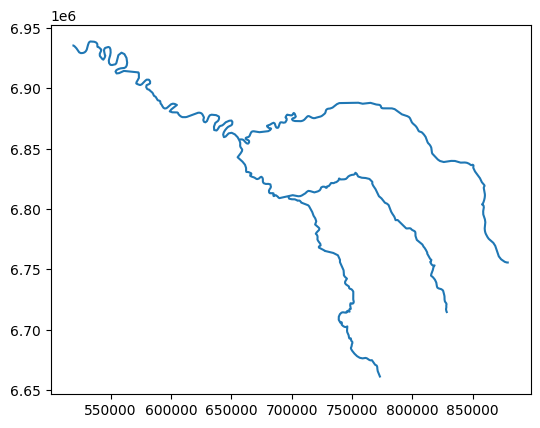

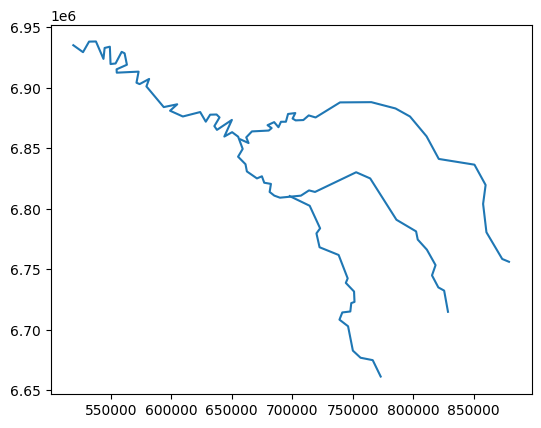

In [4]:
seine_simp = seine.simplify(2000)
seine.plot();
seine_simp.plot();


El objeto resultante seine_simp es una copia del seine original, pero con menos vértices.
Esto es evidente, ya que el resultado es visualmente más simple y consume aproximadamente la mitad de memoria que el objeto original, como se muestra en la comparación a continuación.

In [5]:
print(f'Original: {sys.getsizeof(seine)} bytes')
print(f'Simplified: {sys.getsizeof(seine_simp)} bytes')

Original: 350 bytes
Simplified: 188 bytes


La simplificación también es aplicable a los polígonos.

Esto se ilustra utilizando us_states, que representa los Estados Unidos continentales.
Para muchos cálculos geopandas (a través de shapely y, en última instancia, GEOS) asume que los datos están en un CRS proyectado, lo que podría generar resultados inesperados al aplicar operadores relacionados con la distancia.

Por lo tanto, el primer paso es proyectar los datos en un CRS proyectado adecuado, como el US National Atlas Equal Area (EPSG:9311), utilizando `.to_crs`.

In [6]:
us_states9311 = us_states.to_crs(9311)

El método .simplify de geopandas funciona de la misma manera con una capa de tipo 'Polygon' o 'MultiPolygon', como us_states9311:

In [7]:
us_states_simp1 = us_states9311.simplify(100000)


Una limitación del método `.simplify`, sin embargo, es que simplifica los objetos de forma individual por geometría.
Esto significa que se pierde la topología, lo que da como resultado unidades de área superpuestas y con "agujeros".

El método `.toposimplify` del paquete topojson ofrece una alternativa que supera este problema.
La principal ventaja de `.toposimplify` es que es topológicamente "consciente": simplifica los bordes combinados de los polígonos (en lugar de cada polígono por separado), lo que garantiza que se mantenga la coherencia en los límites.

El siguiente fragmento de código utiliza `.toposimplify` para simplificar us_states9311.
Es importante tener en cuenta que, al usar el paquete topojson, primero debemos calcular un objeto de topología utilizando la función `tp.Topology`, y luego aplicar la función de simplificación, como .toposimplify, para obtener una capa simplificada.
Además, utilizamos el método `.to_gdf` para devolver un GeoDataFrame.

In [8]:
topo = tp.Topology(us_states9311, prequantize=False)
us_states_simp2 = topo.toposimplify(100000).to_gdf()


@fig-simplify-polygons compara los polígonos de entrada originales y dos métodos de simplificación aplicados a us_states9311.


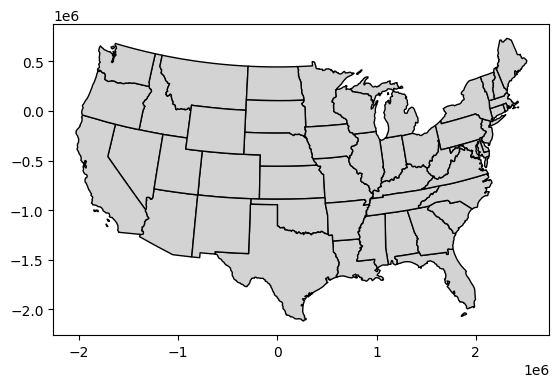

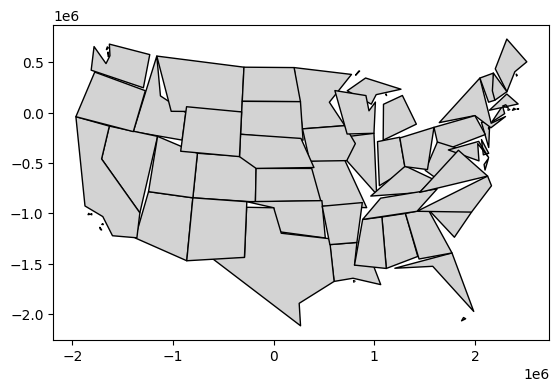

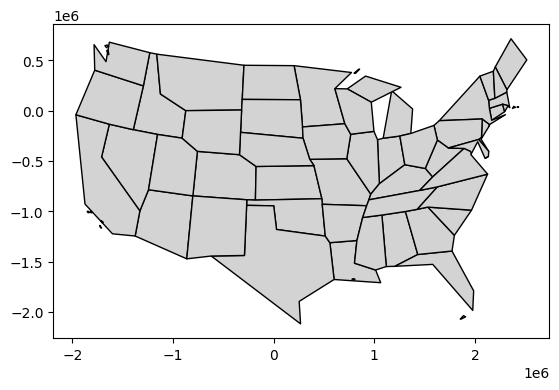

In [9]:
us_states9311.plot(color='lightgrey', edgecolor='black');
us_states_simp1.plot(color='lightgrey', edgecolor='black');
us_states_simp2.plot(color='lightgrey', edgecolor='black');

# **Centroides**

Las operaciones de centroides identifican el centro de los objetos geográficos.
Al igual que las medidas estadísticas de tendencia central (como la media y la mediana), existen varias formas de definir el centro geográfico de un objeto.
Todas ellas crean representaciones de un solo punto para objetos vectoriales más complejos.

El centroide geográfico es el más utilizado, ya que representa el centro de masa de un objeto espacial (como equilibrar un plato en un dedo).
Se usa para simplificar geometrías complejas en puntos, estimar distancias entre polígonos o definir la ubicación de etiquetas en mapas.

En geopandas, los centroides de las geometrías en un GeoSeries o GeoDataFrame se obtienen con la propiedad `.centroid`, como se muestra en el código que genera centroides geográficos para regiones de Nueva Zelanda y afluentes del río Sena.

In [10]:
nz_centroid = nz.centroid
seine_centroid = seine.centroid

A veces, el centroide geográfico se encuentra fuera de los límites de sus objetos de origen (como en el caso de datos vectoriales con forma de rosquilla).

En estos casos, se pueden utilizar operaciones de "punto sobre la superficie" mediante el método `.representative_point`, que garantiza que el punto esté dentro del objeto de origen (por ejemplo, para etiquetar objetos multipoligonales irregulares, como estados insulares), tal como se ilustra con los puntos rojos.

Cabe destacar que estos puntos rojos siempre se encuentran dentro de sus respectivos objetos.

In [11]:
nz_pos = nz.representative_point()
seine_pos = seine.representative_point()

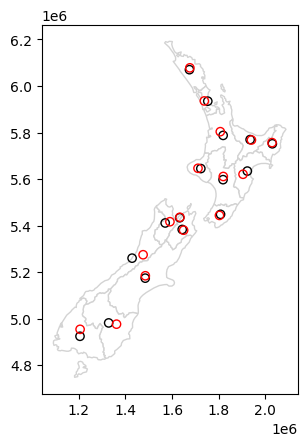

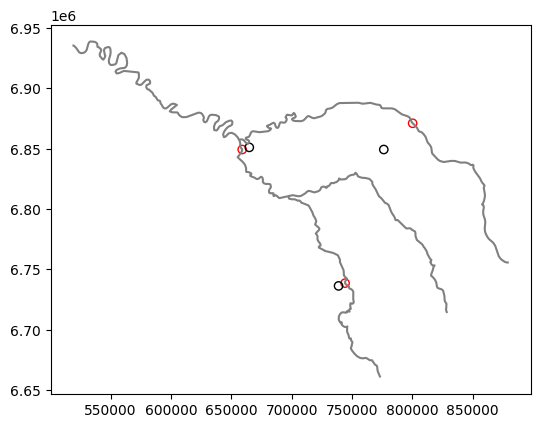

In [12]:
# New Zealand
base = nz.plot(color='white', edgecolor='lightgrey')
nz_centroid.plot(ax=base, color='None', edgecolor='black')
nz_pos.plot(ax=base, color='None', edgecolor='red');
# Seine
base = seine.plot(color='grey')
seine_pos.plot(ax=base, color='None', edgecolor='red')
seine_centroid.plot(ax=base, color='None', edgecolor='black');

# **Áreas de Influencia (Buffers)**

Los buffers son polígonos que representan el área dentro de una distancia determinada de una entidad geométrica.
Independientemente de si la entrada es un punto, una línea o un polígono, la salida siempre será un polígono (cuando se utiliza una distancia de buffer positiva).

A diferencia de la simplificación, que se usa principalmente para visualización y reducción del tamaño de archivos, los buffers se utilizan para el análisis de datos geográficos.
Preguntas como:

¿Cuántos puntos se encuentran dentro de una cierta distancia de esta línea?
¿Qué grupos demográficos están dentro de la distancia de viaje a esta nueva tienda?
Se pueden responder y visualizar creando buffers alrededor de las entidades geográficas de interés.

La figura ilustra buffers de dos tamaños diferentes (5 y 50 km) alrededor del río Sena y sus afluentes.
Estos buffers se crearon utilizando el método .buffer aplicado a un GeoSeries o GeoDataFrame.
El método `.buffer` requiere un argumento fundamental: la distancia del buffer, que se proporciona en las unidades del CRS, en este caso, metros.

In [13]:
seine_buff_5km = seine.buffer(5000)
seine_buff_50km = seine.buffer(50000)

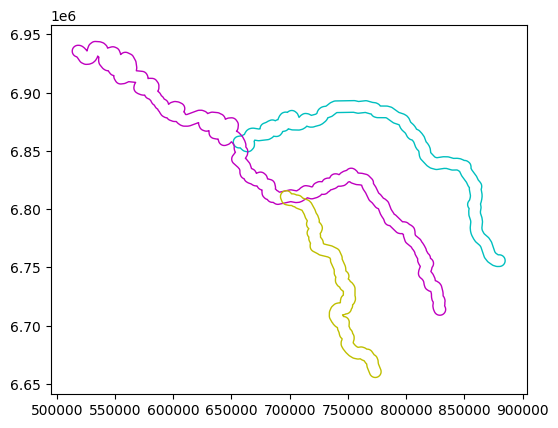

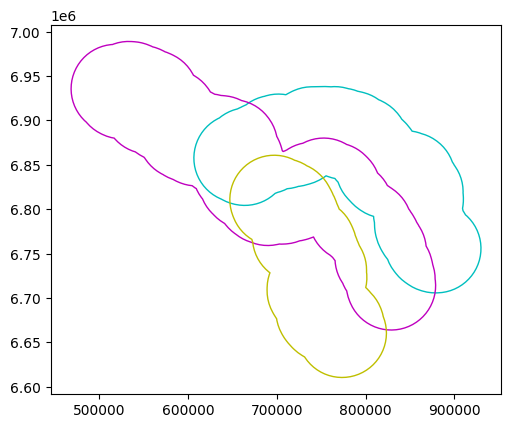

In [14]:
seine_buff_5km.plot(color='none', edgecolor=['c', 'm', 'y']);
seine_buff_50km.plot(color='none', edgecolor=['c', 'm', 'y']);

Cabe destacar que tanto .centroid como .buffer devuelven un objeto GeoSeries, incluso cuando la entrada es un GeoDataFrame.

In [15]:
seine_buff_5km

,0
0,"POLYGON ((657550.332 6852587.977, 657528.383 6..."
1,"POLYGON ((517151.801 6930724.103, 516742.424 6..."
2,"POLYGON ((701519.74 6813075.492, 702765.277 68..."


En el escenario común en el que se necesita conservar los atributos originales de las entidades de entrada, se puede reemplazar la geometría existente con la nueva GeoSeries.
Para ello, se crea una copia del GeoDataFrame original y se asigna la nueva GeoSeries de buffers a la columna geometry.

In [16]:
seine_buff_5km = seine.copy()
seine_buff_5km.geometry = seine.buffer(5000)
seine_buff_5km

,name,geometry
0,Marne,"POLYGON ((657550.332 6852587.977, 657528.383 6..."
1,Seine,"POLYGON ((517151.801 6930724.103, 516742.424 6..."
2,Yonne,"POLYGON ((701519.74 6813075.492, 702765.277 68..."



Una opción alternativa es agregar una columna de geometría secundaria directamente al GeoDataFrame original.

In [17]:
seine['geometry_5km'] = seine.buffer(5000)
seine

,name,geometry,geometry_5km
0,Marne,"MULTILINESTRING ((879955.277 6755724.892, 8784...","POLYGON ((657550.332 6852587.977, 657528.383 6..."
1,Seine,"MULTILINESTRING ((828893.615 6713872.817, 8282...","POLYGON ((517151.801 6930724.103, 516742.424 6..."
2,Yonne,"MULTILINESTRING ((773482.137 6660431.284, 7713...","POLYGON ((701519.74 6813075.492, 702765.277 68..."


Luego, puedes alternar entre cualquiera de las columnas de geometría (es decir, hacerla "activa") utilizando `.set_geometry`, de la siguiente manera:


In [18]:
seine = seine.set_geometry('geometry_5km')

Volvamos al estado original de seine antes de continuar con la siguiente sección.









In [19]:
seine = seine.set_geometry('geometry')
seine = seine.drop('geometry_5km', axis=1)

# **Transformaciones Afines**

Las transformaciones afines incluyen traslación (desplazamiento), escalado, rotación o combinaciones de estas.
Estas transformaciones preservan las líneas y el paralelismo, pero no necesariamente los ángulos y las longitudes.
Son fundamentales en la geocomputación. Por ejemplo:

Traslación: para ubicar etiquetas en un mapa.
Escalado: en cartogramas de áreas no contiguas.
Transformaciones combinadas: al reproyectar o corregir geometrías basadas en mapas distorsionados.
En geopandas, las transformaciones afines se aplican a objetos GeoSeries y GeoDataFrame, afectando solo la parte GeoSeries y devolviendo geometrías transformadas.

Método `.affine_transform`
Este método envuelve la función shapely.affinity.affine_transform y requiere una lista de seis parámetros:
[a, b, d, e, xoff, yoff], que representan las siguientes ecuaciones:


Métodos simplificados para casos específicos:

`.translate(xoff=0.0, yoff=0.0)` → Para desplazar en X o Y.

`.scale(xfact=1.0, yfact=1.0, origin='center')` → Para escalar las geometrías.

`.rotate(angle, origin='center', use_radians=False)` → Para rotar alrededor de un punto.

Por ejemplo, para desplazar coordenadas en el eje Y 100 km al norte (sin afectar el eje X), se usa .translate solo con el parámetro yoff.

In [20]:
nz_shift = nz.translate(0, 100000)
nz_shift

,0
0,"MULTIPOLYGON (((1745493.196 6101802.169, 17405..."
1,"MULTIPOLYGON (((1803822.103 6000006.143, 17914..."
2,"MULTIPOLYGON (((1860345.005 5959664.761, 18578..."
3,"MULTIPOLYGON (((2049387.29 5932785.434, 205101..."
4,"MULTIPOLYGON (((2024489.357 5774919.854, 20190..."
5,"MULTIPOLYGON (((2024489.357 5774919.854, 20241..."
6,"MULTIPOLYGON (((1740438.216 5814538.134, 17438..."
7,"MULTIPOLYGON (((1866732.458 5764323.109, 18689..."
8,"MULTIPOLYGON (((1881590.326 5589434.391, 18756..."
9,"MULTIPOLYGON (((1557042.169 5419333.386, 15542..."


In [21]:
nz_scale = nz.scale(0.5, 0.5, origin='centroid')
nz_scale

,0
0,"MULTIPOLYGON (((1710099.077 6035906.652, 17076..."
1,"MULTIPOLYGON (((1778686.524 5917378.416, 17724..."
2,"MULTIPOLYGON (((1839927.904 5823695.559, 18386..."
3,"MULTIPOLYGON (((1992347.578 5801244.007, 19931..."
4,"MULTIPOLYGON (((2027669.395 5713317.153, 20249..."
5,"MULTIPOLYGON (((1973967.216 5654675.895, 19737..."
6,"MULTIPOLYGON (((1732048.018 5679863.82, 173376..."
7,"MULTIPOLYGON (((1842902.702 5630945.18, 184401..."
8,"MULTIPOLYGON (((1844992.723 5469016.96, 184204..."
9,"MULTIPOLYGON (((1492715.46 5289867.569, 149131..."



Al configurar el parámetro origin en `.scale`, además de 'centroid', es posible usar 'center' (para el centro de la caja delimitadora) o coordenadas de un punto específico, como (0,0).

La rotación de las geometrías se realiza con el método .rotate.
Al rotar, es necesario especificar:

El ángulo de rotación (valores positivos implican rotación en el sentido de las agujas del reloj).
El origen de la rotación (con las mismas opciones que en scale: 'centroid', 'center' o coordenadas específicas).
Por ejemplo, la siguiente expresión rota nz 30° en sentido antihorario, alrededor de los centroides de las geometrías.

In [22]:
nz_rotate = nz.rotate(-30, origin='centroid')
nz_rotate

,0
0,"MULTIPOLYGON (((1701904.887 5975546.319, 16942..."
1,"MULTIPOLYGON (((1779714.772 5879525.45, 176927..."
2,"MULTIPOLYGON (((1890843.462 5829609.742, 18857..."
3,"MULTIPOLYGON (((2065644.972 5767294.222, 20638..."
4,"MULTIPOLYGON (((1986944.148 5688388.418, 19834..."
5,"MULTIPOLYGON (((2031195.949 5618973.361, 20252..."
6,"MULTIPOLYGON (((1772864.383 5696856.981, 17743..."
7,"MULTIPOLYGON (((1893725.223 5631549.764, 18907..."
8,"MULTIPOLYGON (((1892201.458 5447365.954, 18823..."
9,"MULTIPOLYGON (((1569271.697 5247111.335, 15618..."


@fig-affine-transformations shows the original layer `nz`, and the shifting, scaling, and rotation results.

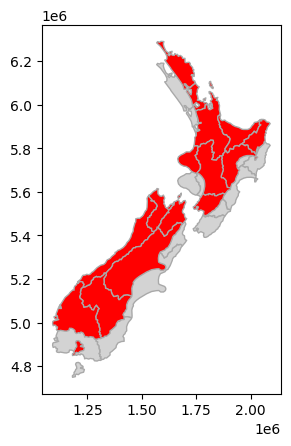

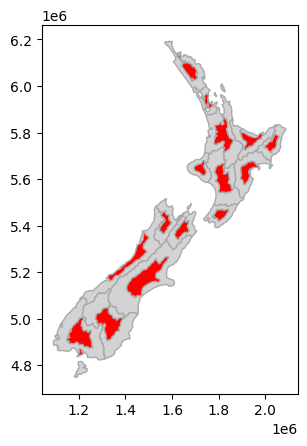

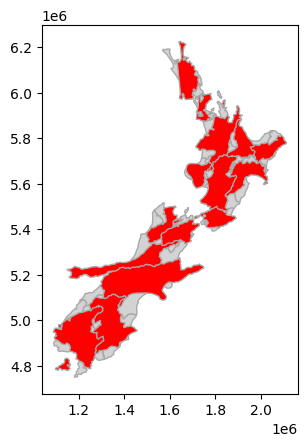

In [23]:
# Shift
base = nz.plot(color='lightgrey', edgecolor='darkgrey')
nz_shift.plot(ax=base, color='red', edgecolor='darkgrey');
# Scale
base = nz.plot(color='lightgrey', edgecolor='darkgrey')
nz_scale.plot(ax=base, color='red', edgecolor='darkgrey');
# Rotate
base = nz.plot(color='lightgrey', edgecolor='darkgrey')
nz_rotate.plot(ax=base, color='red', edgecolor='darkgrey');

# **Operaciones de generación de geometría por pares**

El recorte espacial (spatial clipping) es una forma de subconfiguración espacial que implica cambios en las columnas de geometría de al menos algunas de las entidades afectadas.
El recorte solo se puede aplicar a entidades más complejas que los puntos, como líneas, polígonos y sus equivalentes en formato "multi" (por ejemplo, MultiLineString o MultiPolygon).

Para ilustrar este concepto, comenzaremos con un ejemplo simple: dos círculos superpuestos con un punto central separado por una unidad de distancia y un radio de uno.

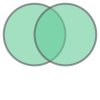

In [24]:
x = shapely.Point((0, 0)).buffer(1)
y = shapely.Point((1, 0)).buffer(1)
shapely.GeometryCollection([x, y])


Imagina que deseas seleccionar no uno de los círculos, sino el espacio cubierto por ambos, x e y.

Esto se puede hacer utilizando el método `.intersection` de shapely, ilustrado con los objetos llamados x e y, que representan los círculos de la izquierda y la derecha, respectivamente.

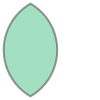

In [25]:
x.intersection(y)


De forma más general, el recorte (clipping) es un ejemplo de una "operación de generación de geometría por pares", donde se generan nuevas geometrías a partir de dos entradas.

Además de `.intersection`, existen otros tres operadores estándar de este tipo:

`.difference`: obtiene la parte de una geometría que no se superpone con la otra.

`.union`: combina ambas geometrías en una sola, incluyendo todas sus áreas.

`.symmetric_difference`: devuelve las áreas que no se superponen, excluyendo la intersección.

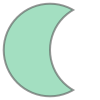

In [26]:
x.difference(y)

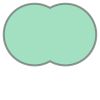

In [27]:
x.union(y)

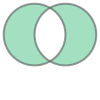

In [28]:
x.symmetric_difference(y)

Ten en cuenta que x e y son intercambiables en todos los predicados, excepto en .difference, donde:

`x.difference(y)` significa x menos y,
mientras que `y.difference(x)` significa y menos x.

## Operaciones por pares en shapely y geopandas

Los ejemplos anteriores muestran operaciones por pares entre geometrías individuales de shapely.
Sin embargo, el paquete geopandas incluye wrappers de estas funciones para aplicarlas en múltiples casos de uso, ya sea:

Uno a uno (pairwise) o Muchos a uno (many-to-one).

Por ejemplo, al aplicar cualquiera de estos métodos por pares en un GeoSeries o GeoDataFrame, combinado con una geometría de shapely, se obtienen resultados de tipo many-to-one.
Esto es similar a otros operadores, como `.intersects` o `.distance`.

Ejemplo: Escenario "many-to-one"

Vamos a demostrar el escenario many-to-one calculando la diferencia entre cada geometría en un GeoSeries y una geometría fija de shapely.
Para crear esta última, tomaremos x y la combinaremos consigo misma, desplazándola a una distancia de 1 y 2 unidades hacia arriba en el eje Y.

In [29]:
geom1 = gpd.GeoSeries(x)
geom2 = geom1.translate(0, 1)
geom3 = geom1.translate(0, 2)
geom = pd.concat([geom1, geom2, geom3])
geom

,0
0,"POLYGON ((1 0, 0.99518 -0.09802, 0.98079 -0.19..."
0,"POLYGON ((1 1, 0.99518 0.90198, 0.98079 0.8049..."
0,"POLYGON ((1 2, 0.99518 1.90198, 0.98079 1.8049..."


@fig-geom-intersection muestra el GeoSeries geom junto con la geometría de shapely (en rojo) con la que realizaremos la intersección.

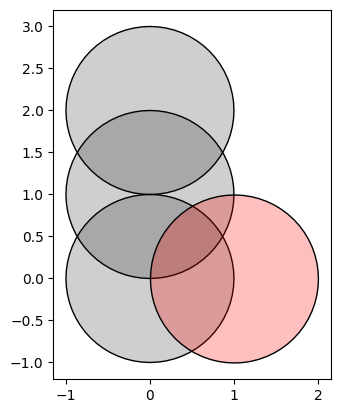

In [30]:
fig, ax = plt.subplots()
geom.plot(color='#00000030', edgecolor='black', ax=ax)
gpd.GeoSeries(y).plot(color='#FF000040', edgecolor='black', ax=ax);

Ahora, al usar .intersection, se aplica automáticamente el método de shapely con el mismo nombre sobre cada geometría en geom, devolviendo un nuevo GeoSeries, que llamamos geom_inter_y, con las intersecciones por pares.

Observa que la tercera geometría está vacía.
¿Puedes explicar el significado de este resultado?

➡️ Significado: Esto indica que no hay intersección entre la tercera geometría de geom y la geometría de shapely (en rojo). En otras palabras, no comparten ningún área en común, lo que da como resultado una geometría vacía.

In [31]:
geom_inter_y = geom.intersection(y)
geom_inter_y

,0
0,"POLYGON ((0.99518 -0.09802, 0.98079 -0.19509, ..."
0,"POLYGON ((0.99518 0.90198, 0.98079 0.80491, 0...."
0,POLYGON EMPTY


@fig-geom-intersection2 is a plot of the result `geom_inter_y`.

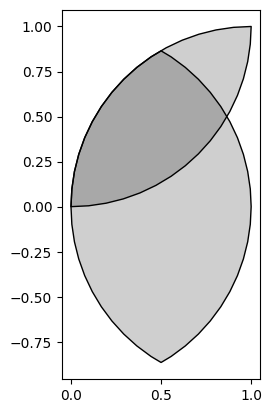

In [32]:
geom_inter_y.plot(color='#00000030', edgecolor='black');

El método `.overlay()` amplía aún más esta técnica, permitiendo realizar operaciones geométricas emparejadas de tipo "muchos a muchos" entre todos los pares de dos GeoDataFrame.

El resultado es un nuevo GeoDataFrame que contiene:

Las geometrías resultantes de cada par de combinaciones.
Los atributos de ambos conjuntos de datos originales que participaron en la operación.
Este método es útil para operaciones como intersección, unión, diferencia y diferencia simétrica entre capas geográficas.



<!-- ## Exercises -->